In [1]:
import os
import sys
from typing import Optional, Tuple

import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append(os.path.join('..', '..'))
from tta_uia_segmentation.src.dataset.io import get_datasets
from tta_uia_segmentation.src.utils.io import load_config
from tta_uia_segmentation.src.utils.utils import torch_to_numpy
from tta_uia_segmentation.src.dataset.utils import onehot_to_class

def plot_torch_img(img_, return_img: bool = False, **kwargs):
    img = torch_to_numpy(img_.squeeze())
    plt.imshow(img, cmap='gray', **kwargs)

    if return_img:
        return img
    
def plot_torch_seg(seg_, class_dim, return_img: bool = False, **kwargs):
    img = torch_to_numpy(onehot_to_class(seg_, class_dim).squeeze())

    plt.imshow(img, cmap='tab20', interpolation='none', **kwargs)

    if return_img:
        return img

def plot_pcs(
        x_pcs,
        component_group: int = 0,
        format: str = 'CHW', 
        output_size: Optional[Tuple[int, int]] = None,
        return_img: bool = False,
        **kwargs):
    # Make channel last
    if format == 'CHW':
        x_pcs = x_pcs.permute(1, 2, 0)
    elif format == 'HWC':
        pass
    else:
        raise ValueError(f'Unknown format: {format}')

    # Choose the group of PCs to visualize in RGB
    x_pcs = x_pcs[: , :, component_group: component_group + 3]

    # Normalize to [0, 1]
    per_channel_min = x_pcs.view(-1, 3).min(dim=0).values
    per_channel_max = x_pcs.view(-1, 3).max(dim=0).values
    x_pcs = (x_pcs - per_channel_min) / (per_channel_max - per_channel_min)

    if output_size is not None:
        x_pcs = F.interpolate(x_pcs.permute(2, 0, 1).unsqueeze(0), output_size, mode='bilinear', align_corners=True)
        x_pcs = x_pcs.squeeze(0).permute(1, 2, 0)

    plt.imshow(x_pcs, **kwargs)

    if return_img:
        return x_pcs



/scratch_net/biwidl319/jbermeo/GNN-Domain-Generalization-main/net_scratch/conda_envs/tta_uia_seg/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
dataset_names = ['hcp_t2', 'abide_stanford']
split = 'train'
dino_model = 'large'
hierarchy_level = 2

## Load Datasets with preprocessed Dino Features

In [3]:
dataset_cfg_all = load_config('../../config/datasets.yaml')

datasets = dict()
for dataset_name in dataset_names:
    dataset_cfg = dataset_cfg_all[dataset_name]

    dataset_kwargs = dict(
        dataset_type    = 'DinoFeatures',
        splits          = [split],
        paths_preprocessed = dataset_cfg['paths_preprocessed'],
        paths_original  = dataset_cfg['paths_original'],
        paths_preprocessed_dino  = dataset_cfg['paths_preprocessed_dino'],
        dino_model      = dino_model,
        hierarchy_level = hierarchy_level,
        resolution_proc = dataset_cfg['resolution_proc'],
        dim_proc        = dataset_cfg['dim'],
        n_classes       = dataset_cfg['n_classes'],
        load_original   = False,
        load_in_memory  = False,
        aug_params      = None,
        mode            = '2D',
        orientation     = 'depth'  
    )

    datasets[dataset_name] = get_datasets(
        dataset_name=dataset_name,
        **dataset_kwargs
        )[0]


## Load IPCA model

In [4]:
from tta_uia_segmentation.src.models.pca.IncrementalPCA import IncrementalPCA

ipca_path = "/scratch/jbermeo/logs_bmicnas_01/subcortical_structures/pca/abide_stanford/incremental_pca/dino/large/hierachies_0_1_2_new_attempt"
suffix = 'last'

ipca = IncrementalPCA.load_pca(os.path.join(ipca_path, f'ipca_{suffix}.pkl'))

## Check PC representation from SD and TD

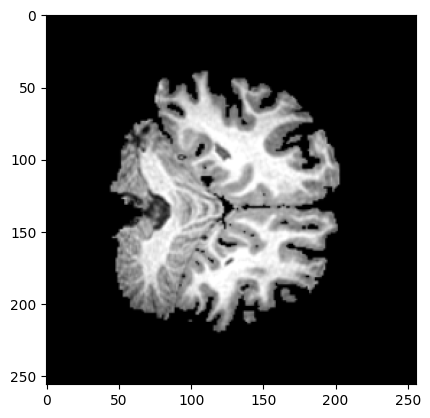

In [5]:
sd_slice = 40
sd_img, sd_seg, *_  = datasets['abide_stanford'].get_preprocessed_items(sd_slice)
plot_torch_img(sd_img)

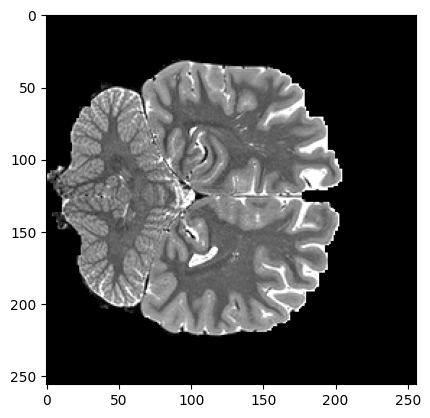

In [6]:
td_slice = 80
td_img, td_seg, *_  = datasets['hcp_t2'].get_preprocessed_items(td_slice)
plot_torch_img(td_img)

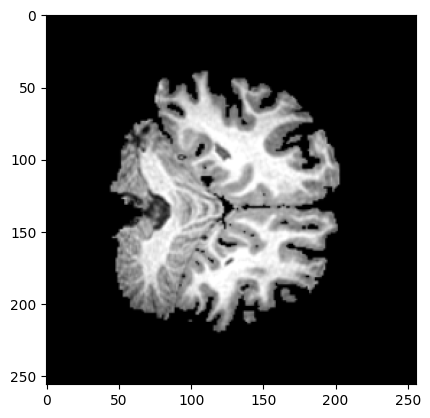

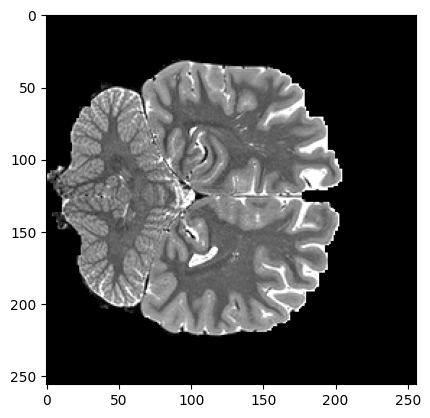

In [7]:
sd_slice = 40
sd_img, sd_seg, *_  = datasets['abide_stanford'].get_preprocessed_items(sd_slice)
sd_img_dino_fe = datasets['abide_stanford'][sd_slice][0][2]
sd_img_pcs = ipca.img_to_pcs(sd_img_dino_fe)[0]

td_slice = 80
td_img, td_seg, *_  = datasets['hcp_t2'].get_preprocessed_items(td_slice)
td_img_dino_fe = datasets['hcp_t2'][td_slice][0][2]
td_img_pcs = ipca.img_to_pcs(td_img_dino_fe)[0]

plot_torch_img(sd_img)
plt.show()

plot_torch_img(td_img)
plt.show()

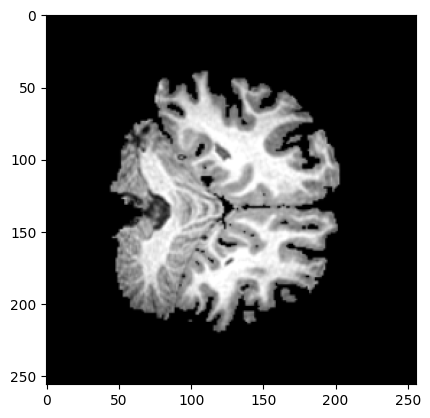

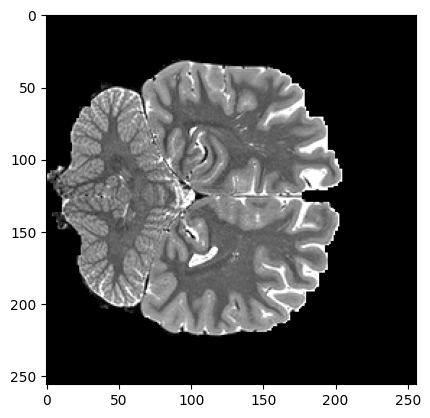

In [8]:
sd_slice = 40
sd_img, sd_seg, *_  = datasets['abide_stanford'].get_preprocessed_items(sd_slice)
sd_img_dino_fe = datasets['abide_stanford'][sd_slice][0][2]
sd_img_pcs = ipca.img_to_pcs(sd_img_dino_fe)[0]

td_slice = 80
td_img, td_seg, *_  = datasets['hcp_t2'].get_preprocessed_items(td_slice)
td_img_dino_fe = datasets['hcp_t2'][td_slice][0][2]
td_img_pcs = ipca.img_to_pcs(td_img_dino_fe)[0]

plot_torch_img(sd_img)
plt.show()

plot_torch_img(td_img)
plt.show()

In [9]:
def plot_sd_and_td_imgs_w_pcs(
    sd_img, sd_seg, sd_imgs_pcs,
    td_img, td_seg, td_imgs_pcs,
    pc_groups: tuple[int, ...],
    n_classes: int,
):
    # Create plot with two rows
    fig, axs = plt.subplots(2, 2 + len(pc_groups), figsize=(20, 10))

    # Plot SD image and segmentation
    axs[0, 0].imshow(plot_torch_img(sd_img, return_img=True), cmap='gray')
    axs[0, 0].set_title('SD Image')
    axs[0, 1].imshow(plot_torch_seg(sd_seg, 0, return_img=True), cmap='tab20', interpolation='none', vmin=0, vmax=n_classes-1)
    axs[0, 1].set_title('SD Segmentation')

    for i, (pc_group) in enumerate(pc_groups):
        axs[0, i + 2].imshow(plot_pcs(sd_imgs_pcs, pc_group, 'CHW', return_img=True), vmin=0, vmax=1, interpolation='none')
        axs[0, i + 2].set_title(f'SD PC {3 * pc_group} - {3 * pc_group + 2}')

    # Plot TD image and segmentation
    axs[1, 0].imshow(plot_torch_img(td_img, return_img=True), cmap='gray')
    axs[1, 0].set_title('TD Image')
    axs[1, 1].imshow(plot_torch_seg(td_seg, 0, return_img=True), cmap='tab20', interpolation='none', vmin=0, vmax=n_classes-1)
    axs[1, 1].set_title('TD Segmentation')

    for i, (pc_group) in enumerate(pc_groups):
        axs[1, i + 2].imshow(plot_pcs(td_imgs_pcs, pc_group, 'CHW', return_img=True), vmin=0, vmax=1, interpolation='none')
        axs[0, i + 2].set_title(f'TD PC {3 * pc_group} - {3 * pc_group + 2}')

    plt.show()



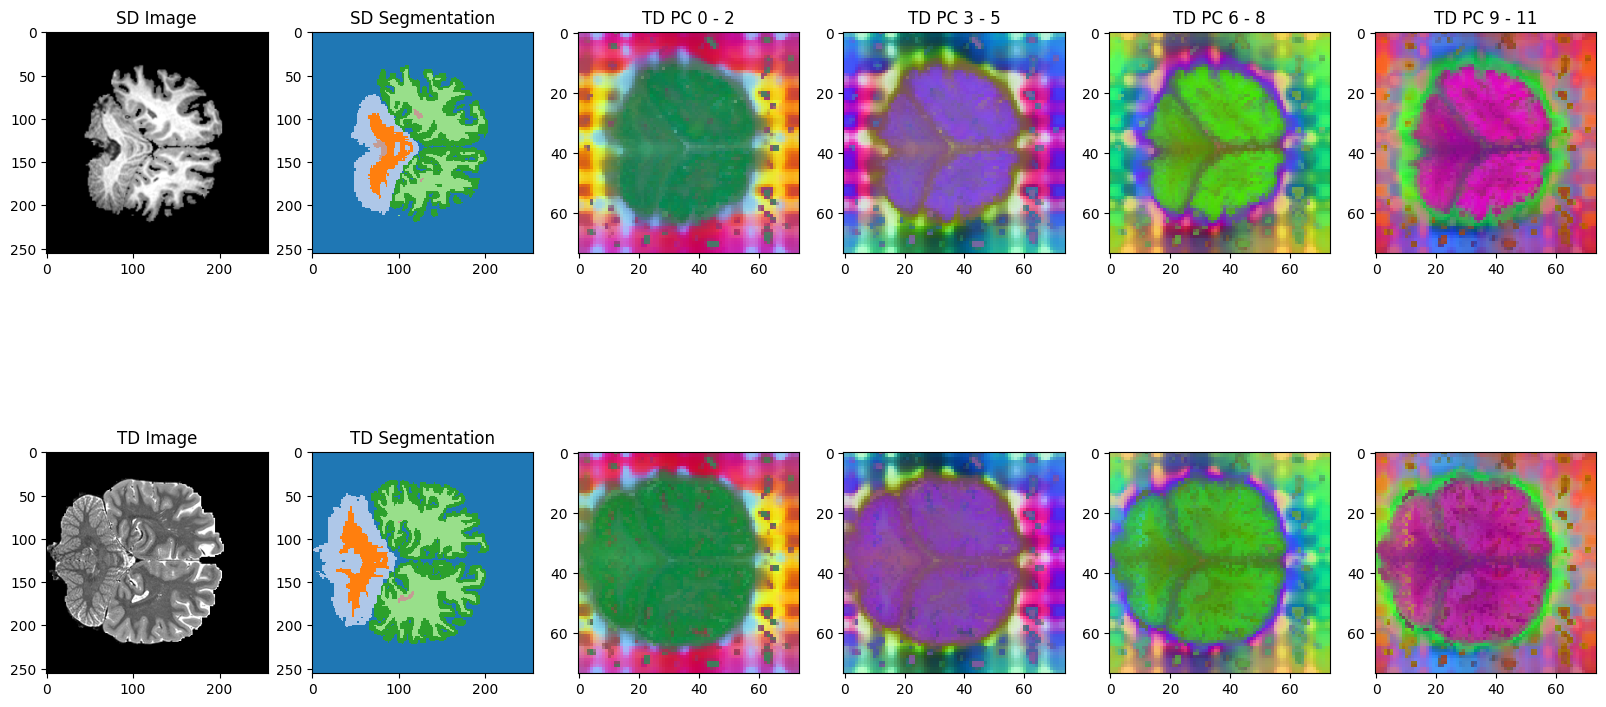

In [10]:
plot_sd_and_td_imgs_w_pcs(sd_img, sd_seg, sd_img_pcs, td_img, td_seg, td_img_pcs, range(4), n_classes=15)

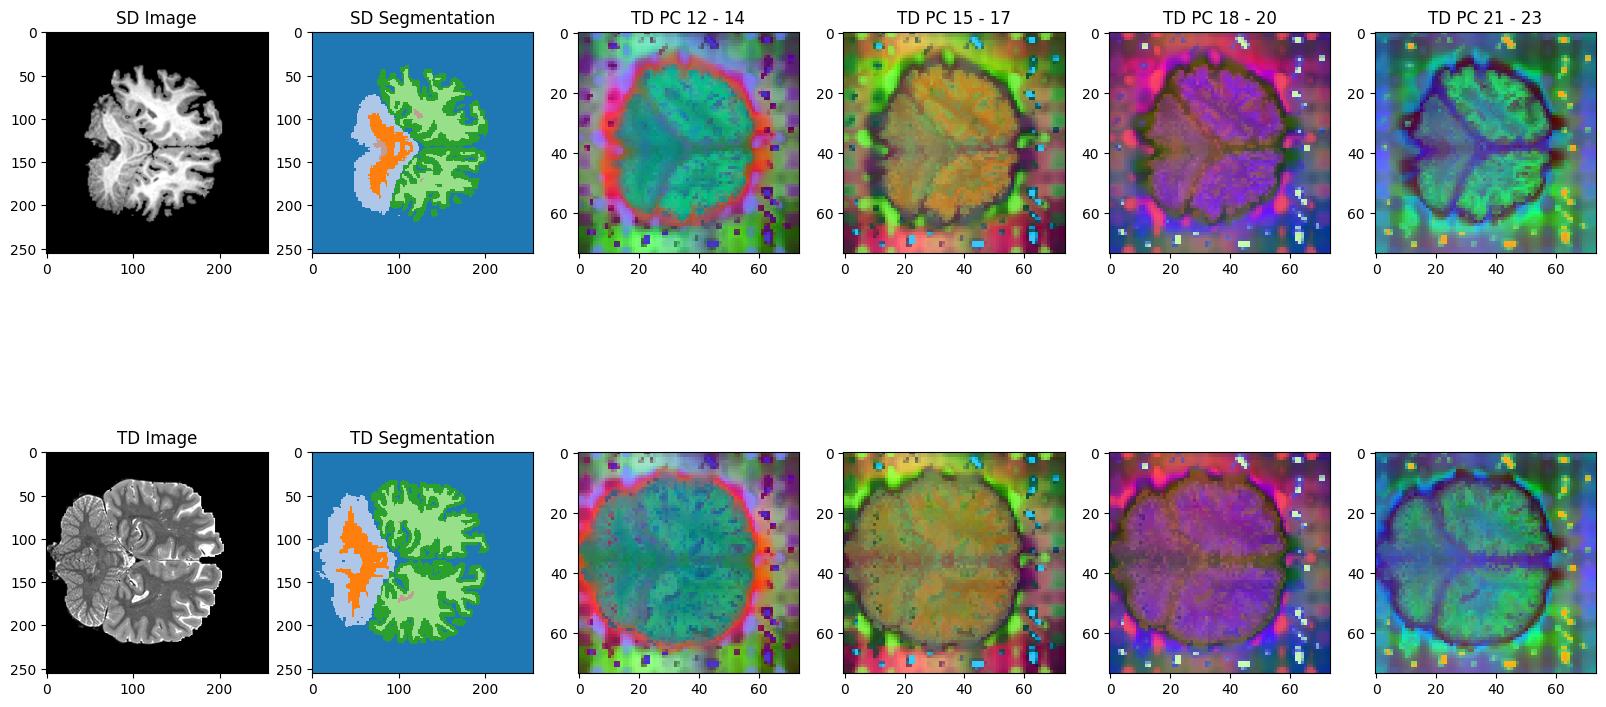

In [11]:
plot_sd_and_td_imgs_w_pcs(sd_img, sd_seg, sd_img_pcs, td_img, td_seg, td_img_pcs, range(4, 8), n_classes=15)

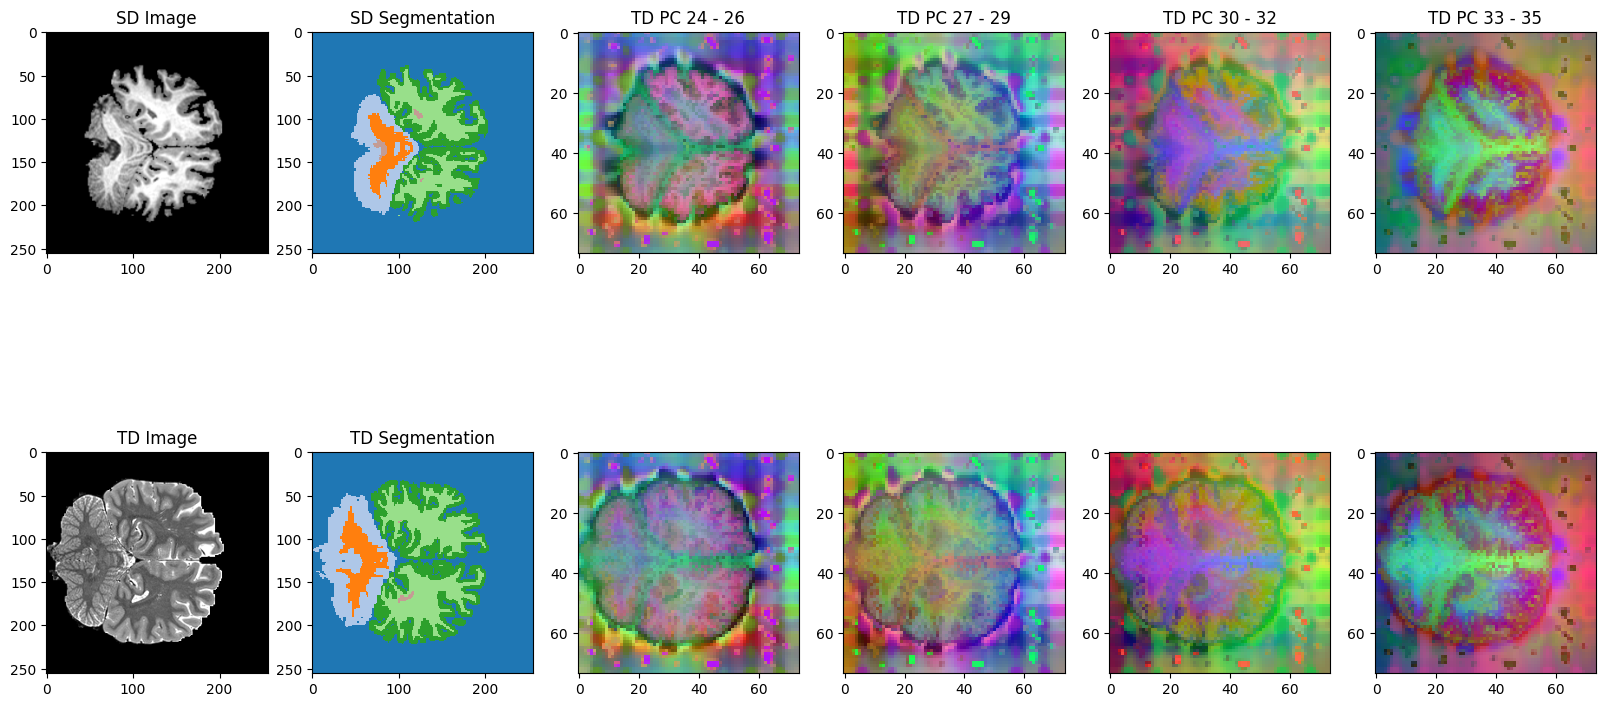

In [12]:
plot_sd_and_td_imgs_w_pcs(sd_img, sd_seg, sd_img_pcs, td_img, td_seg, td_img_pcs, range(8, 12), n_classes=15)

Looks good. Repeat when computing in PCs with Pytorch and check we get the same images

In [13]:
ipca.use_torch = True
sd_img_pcs = ipca.img_to_pcs(sd_img_dino_fe)[0]
td_img_pcs = ipca.img_to_pcs(td_img_dino_fe)[0]

In [14]:
td_img_pcs.shape

torch.Size([1024, 74, 74])

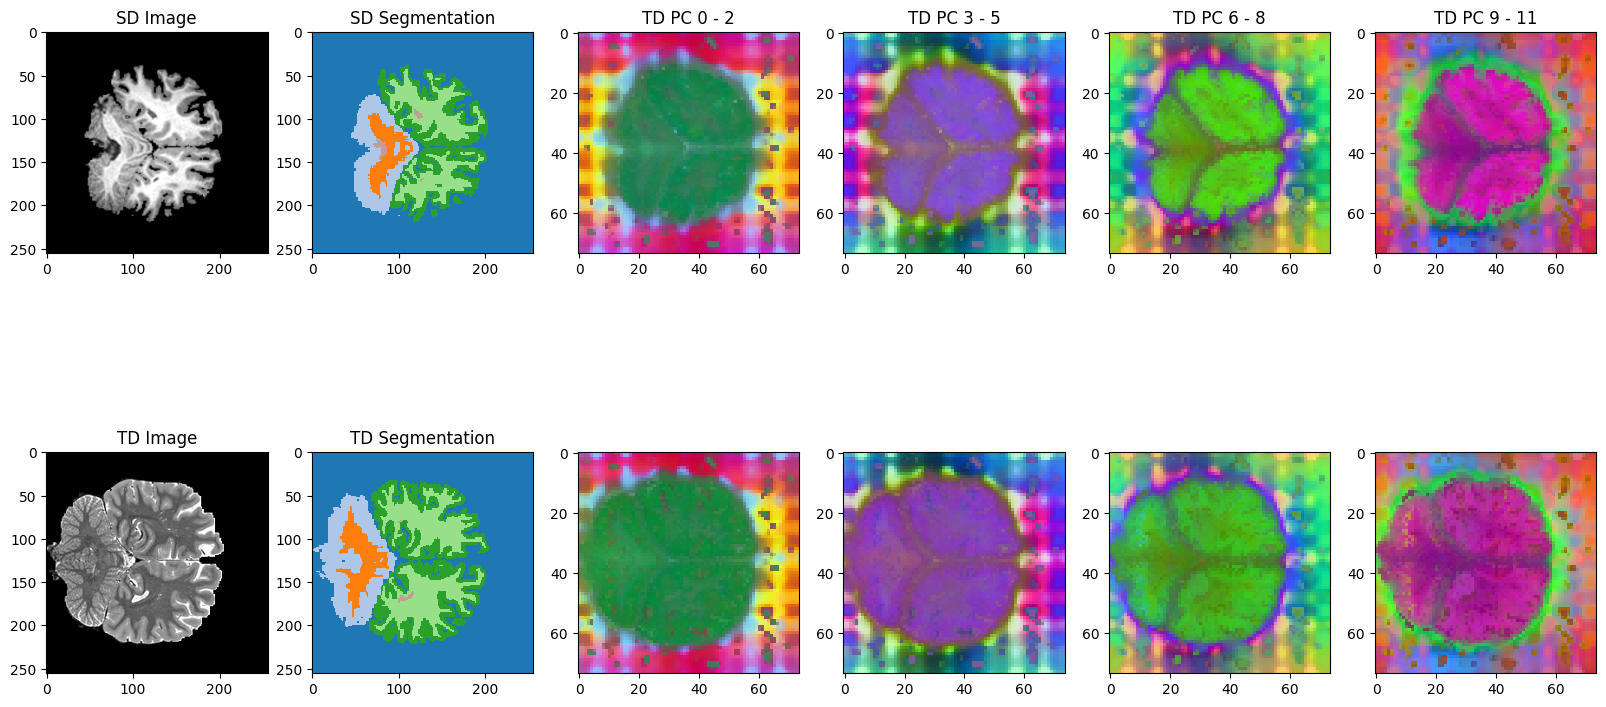

In [15]:
plot_sd_and_td_imgs_w_pcs(sd_img, sd_seg, sd_img_pcs, td_img, td_seg, td_img_pcs, range(4), n_classes=15)

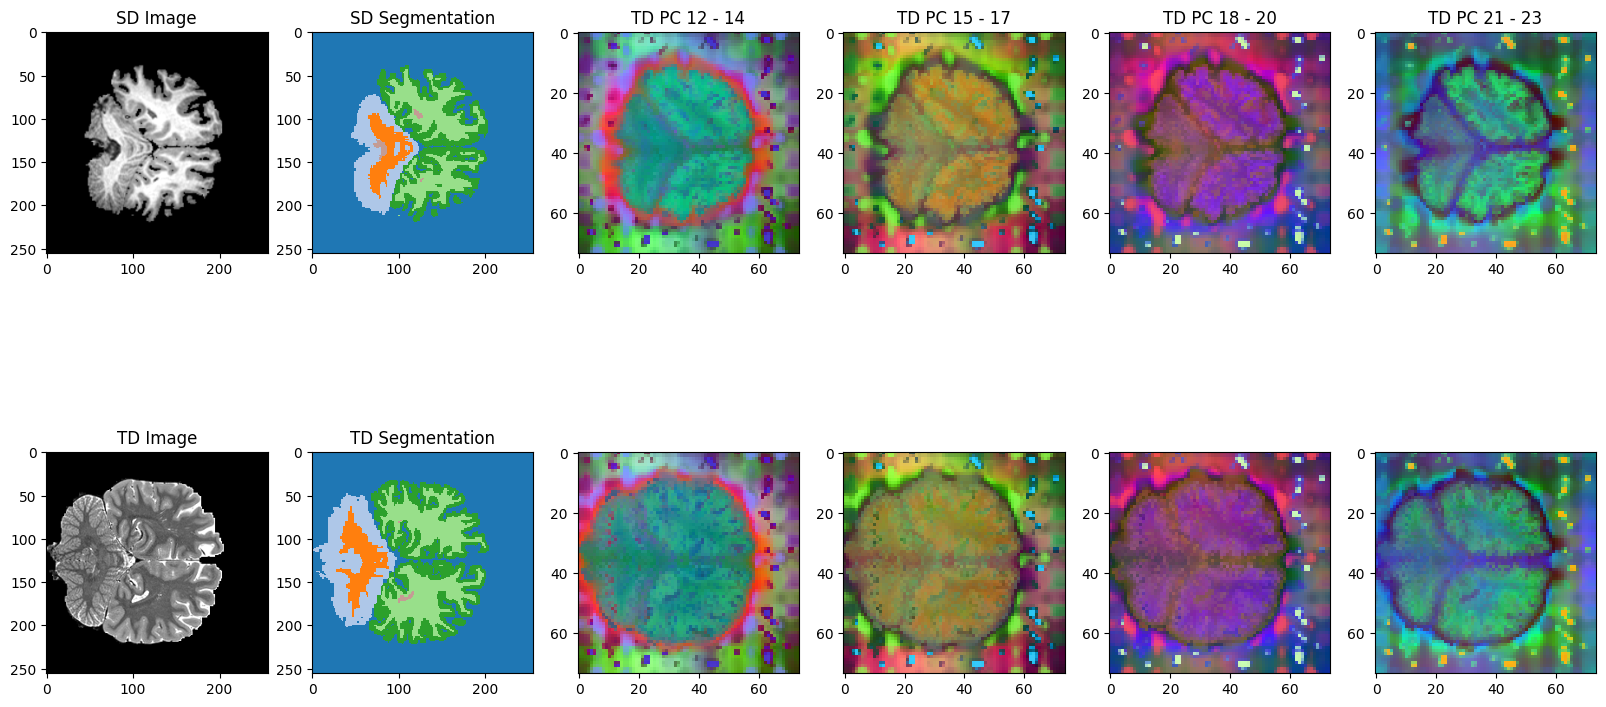

In [16]:
plot_sd_and_td_imgs_w_pcs(sd_img, sd_seg, sd_img_pcs, td_img, td_seg, td_img_pcs, range(4, 8), n_classes=15)

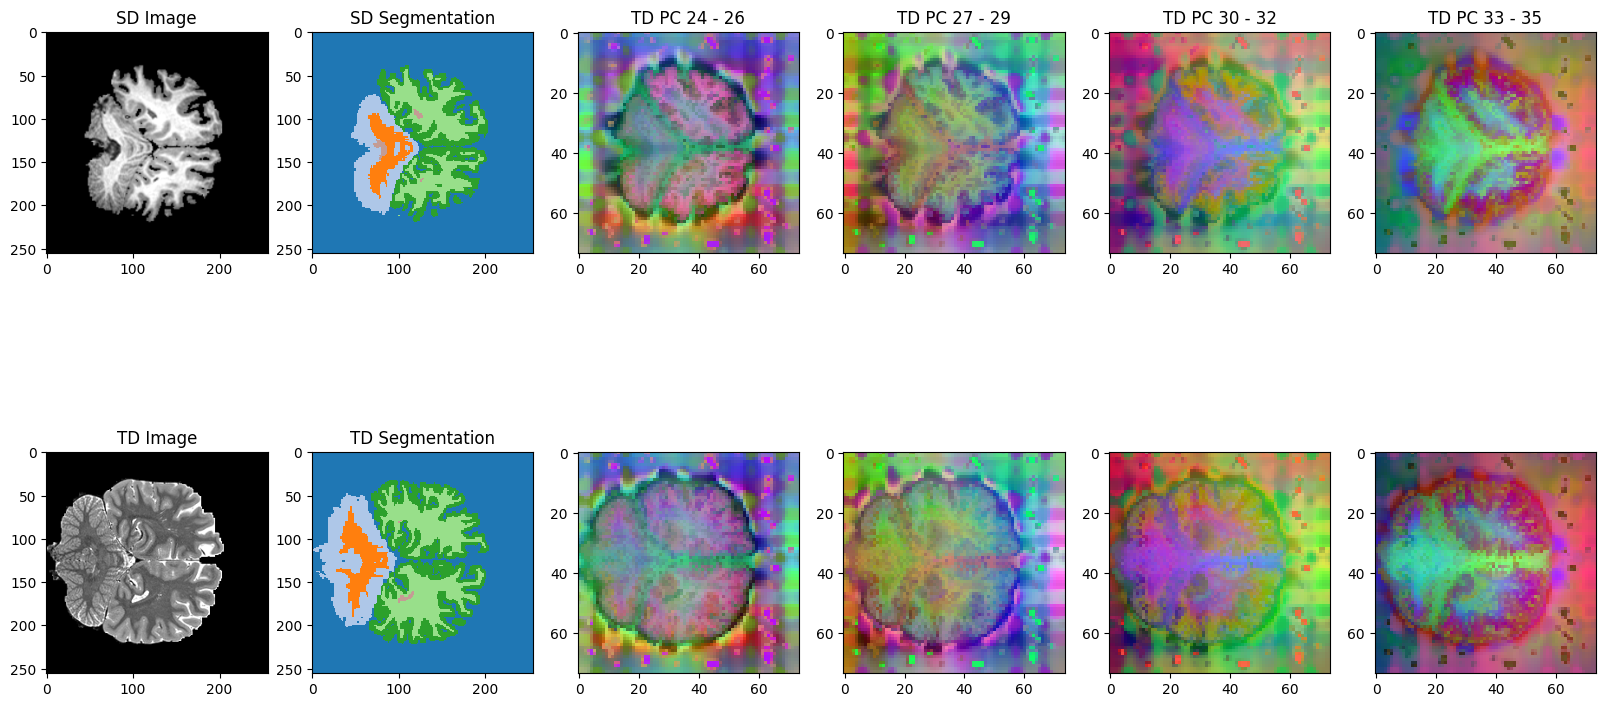

In [17]:
plot_sd_and_td_imgs_w_pcs(sd_img, sd_seg, sd_img_pcs, td_img, td_seg, td_img_pcs, range(8, 12), n_classes=15)

Looks good

## Check Reconstruction Metrics

In [18]:
from torch.nn.functional import mse_loss

In [19]:
ipca.use_torch = False
mse_loss(sd_img_dino_fe.unsqueeze(0), ipca.img_reconstruct(sd_img_dino_fe.unsqueeze(0)))

tensor(2.0445e-15, dtype=torch.float64)

In [20]:
ipca.use_torch = True
mse_loss(sd_img_dino_fe.unsqueeze(0), ipca.img_reconstruct(sd_img_dino_fe.unsqueeze(0)))

tensor(2.8154e-13)

In [21]:
ipca.use_torch = False
ipca.n_components = 1000

z_10_sklearn = ipca.img_to_pcs(sd_img_dino_fe)[0]


ipca.use_torch = True
ipca.n_components = 1000
z_10_torch = ipca.img_to_pcs(sd_img_dino_fe)[0]

import torch
print(torch.isclose(z_10_sklearn.float(), z_10_torch.float(), atol=1e-5).all())
print(torch.isclose(z_10_sklearn.float(), z_10_torch.float(), atol=1e-7).all())

tensor(True)
tensor(False)


In [22]:
z_10_sklearn.shape

torch.Size([1000, 74, 74])

In [23]:
z_10_torch.shape

torch.Size([1000, 74, 74])

Let's check with less components

In [24]:
ipca.n_components = 10
ipca.use_torch = False
mse_sklearn = mse_loss(sd_img_dino_fe.unsqueeze(0), ipca.img_reconstruct(sd_img_dino_fe.unsqueeze(0)))
print(f'MSE sklearn: {mse_sklearn}')


ValueError: Reconstructing the data with a different number of  components than the fitted model is not supported.
 The model was fitted with 10 components, but you are trying to reconstruct with 1024 components

In [25]:

ipca.use_torch = True
mse_torch = mse_loss(sd_img_dino_fe.unsqueeze(0), ipca.img_reconstruct(sd_img_dino_fe.unsqueeze(0)))
print(f'MSE torch: {mse_torch}')

MSE torch: 0.6857268810272217
